<a href="https://colab.research.google.com/github/VladislavTumanov/bookish-computing-machine/blob/main/Credit_scoring_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import requests
import io 
import seaborn as sns
import torch 
from matplotlib import pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction import DictVectorizer
import scipy
from sklearn.model_selection import  StratifiedKFold
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import adjusted_rand_score
from tqdm import tqdm
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [2]:
import warnings
warnings.filterwarnings("ignore")

#function which is used when need NaN value replace on median
def delete_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table

In [3]:
from google.colab import files
uploaded = files.upload()

Saving credit_scoring_sample.csv to credit_scoring_sample.csv


In [4]:
data = pd.read_csv((io.BytesIO(uploaded['credit_scoring_sample.csv'])), sep=";")
data

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0
...,...,...,...,...,...,...,...,...
45058,1,31,0,0.824725,0,0,3000.0,1.0
45059,0,49,0,6530.000000,0,0,0.0,5.0
45060,1,38,0,0.475841,0,0,3000.0,2.0
45061,0,47,1,0.485198,0,0,11720.0,5.0


In [7]:
for i in data.columns:
  print(i, 'number of nan is',sum(np.isnan(data[i])))

SeriousDlqin2yrs number of nan is 0
age number of nan is 0
NumberOfTime30-59DaysPastDueNotWorse number of nan is 0
DebtRatio number of nan is 0
NumberOfTimes90DaysLate number of nan is 0
NumberOfTime60-89DaysPastDueNotWorse number of nan is 0
MonthlyIncome number of nan is 8643
NumberOfDependents number of nan is 1117


In [18]:
data.describe()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
count,45063.000000,45063.000000,45063.000000,45063.000000,45063.000000,45063.000000,3.642000e+04,43946.000000
mean,0.222489,51.210949,0.750993,352.062688,0.570712,0.505870,6.452263e+03,0.789628
std,0.415922,14.651533,6.184521,2467.556358,6.173106,6.153609,1.263817e+04,1.130813
min,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,0.000000,40.000000,0.000000,0.176373,0.000000,0.000000,3.286000e+03,0.000000
50%,0.000000,51.000000,0.000000,0.373949,0.000000,0.000000,5.166000e+03,0.000000
75%,0.000000,62.000000,0.000000,0.857027,0.000000,0.000000,8.000000e+03,1.000000
max,1.000000,107.000000,98.000000,326442.000000,98.000000,98.000000,1.794060e+06,10.000000


In [20]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

In [48]:
np.unique(data['SeriousDlqin2yrs'])

array([0, 1])

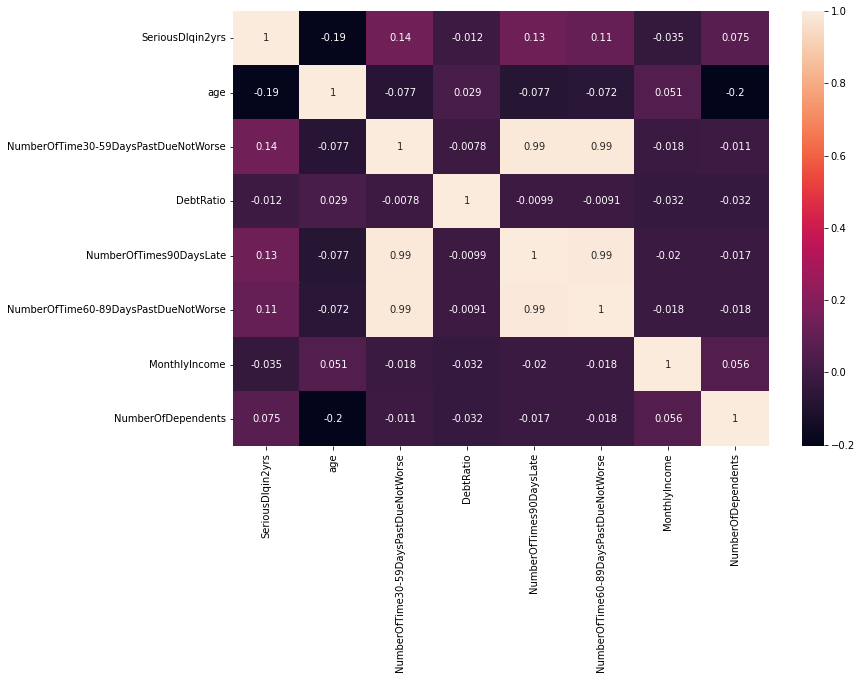

In [49]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(data.corr(), annot = True)

In [50]:
independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [51]:
table = delete_nan(data)

In [52]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

In [53]:
#function for genetare samples with bootstrap
def get_bootstrap_samples(info, n_sample):
  indicates = np.random.randint(0, len(info), (n_sample, len(info)))
  samples = info[indicates]
  return samples

# function for determine interval estimation
def stat_intervals(stat, alpha):
  boundaries = np.percentile(stat,[100*alpha/2, 100*(1-alpha/2)])
  return boundaries

churn_debt = data[data['SeriousDlqin2yrs']==1]['age'].values

np.random.seed(0)

churn_mean_scores = [np.mean(sample) for sample in get_bootstrap_samples(churn_debt, 1000)]

print("Service calls from churn:  mean interval", stat_intervals(churn_mean_scores, 0.1))

Service calls from churn:  mean interval [45.71379414 46.12700479]


As a result, we got that with 90% probability the average age of the client who has not paid the debt will be in the range between 45 and 46

# Logistic Regression

In [45]:
lr = LogisticRegression(random_state=5, class_weight="balanced")
parameters = {"C": (0.0001, 0.001, 0.01, 0.1, 1, 10)}
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 5)

In [54]:
grid = GridSearchCV(lr, parameters, scoring ='roc_auc', cv=skf, n_jobs = -1)
grid.fit(X, y)
grid.best_estimator_

LogisticRegression(C=0.001, class_weight='balanced', random_state=5)

In [55]:
print(grid.cv_results_['std_test_score'])
grid.best_score_

[0.00729217 0.00813756 0.0079516  0.00516327 0.00735948 0.0051725 ]


0.8089120626797153

In [56]:
lr = LogisticRegression(C = 0.001,random_state=5, class_weight="balanced")
sc = StandardScaler()
X_norm = sc.fit_transform(X)
lr.fit(X_norm, y)

pd.DataFrame({'features' : independent_columns_names, 'coef': lr.coef_.flatten().tolist()}).sort_values(by = 'coef',  ascending=False)

,features,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.723427
3,NumberOfTimes90DaysLate,0.516788
4,NumberOfTime60-89DaysPastDueNotWorse,0.193558
6,NumberOfDependents,0.101443
2,DebtRatio,-0.024096
5,MonthlyIncome,-0.163146
0,age,-0.416702


In [57]:
np.exp(lr.coef_[0][2]) / sum(np.exp(lr.coef_[0]))

0.11426375283065268

In [58]:
lr = LogisticRegression(C=0.001,  random_state=5, class_weight= 'balanced')
lr.fit(X, y)

pd.DataFrame({'feat': independent_columns_names,
              'coef': lr.coef_.flatten().tolist()}).sort_values(by='coef', ascending=False)

np.exp(lr.coef_[0][0]*20)

0.761008699166776

if you increase the age by 20 years, the chances that a person will not pay off the loan will increase by 0.76.

# Random Forest

In [ ]:
rf = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=42,
    oob_score=True,
    class_weight="balanced",
)

parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15],
}

skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 5)

gs = GridSearchCV(rf, parameters, n_jobs = - 1, scoring ='roc_auc', cv=skf)
gs.fit(X,y)
gs.best_score_

0.8357785379863423

In [ ]:
gs.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=2,
                       min_samples_leaf=9, n_jobs=-1, oob_score=True,
                       random_state=42)

In [ ]:
rf = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=42,
    oob_score=True,
    class_weight="balanced",
    max_depth=10,
    max_features=2,
    min_samples_leaf=9)

rf.fit(X,y)

independent_columns_names[np.argmin(rf.feature_importances_)]

'NumberOfDependents'

In [ ]:
parameters = {
    "max_features": [2, 3, 4],
    "max_samples": [0.5, 0.7, 0.9],
    "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100],
}

bg = BaggingClassifier(LogisticRegression(class_weight='balanced'), n_estimators=100, n_jobs=-1, random_state=42)

r_grid_search = RandomizedSearchCV(bg,parameters, n_jobs=-1, scoring ='roc_auc', random_state=42, n_iter=20, cv = skf, verbose=True)

r_grid_search = r_grid_search.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [ ]:
r_grid_search.best_score_

0.8085323694398069